# Single-cell RNA-seq analysis workflow for 1M cells using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Import requirements

In [1]:
import time

import numpy as np
import scanpy as sc
from sklearn.cluster import KMeans

import os, wget

import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"
USE_FIRST_N_CELLS = 1000000

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
              input_file)

## Set parameters

In [3]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# Batched PCA
pca_train_ratio = 0.35 # percentage of cells to use for PCA training, when using batched PCA function
n_pca_batches = 10 # number of batches, when using batched PCA function

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs
sc.settings.n_jobs=32

In [4]:
start = time.time()

## Load and Prepare Data

In [5]:
%%time
adata = sc.read(input_file)
adata.var_names_make_unique()
adata.shape

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CPU times: user 1min 48s, sys: 11.4 s, total: 2min
Wall time: 1min 59s


(1306127, 27998)

In [6]:
adata = adata[0:USE_FIRST_N_CELLS]
adata.shape

(1000000, 27998)

## Preprocessing

In [7]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [8]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

Trying to set attribute `.obs` of view, copying.


CPU times: user 2min 2s, sys: 1min 1s, total: 3min 3s
Wall time: 3min 3s


Some genes will now have zero expression in all cells. We filter out such genes.

In [9]:
%%time
sc.pp.filter_genes(adata, min_cells=1)

CPU times: user 23.1 s, sys: 10.9 s, total: 34.1 s
Wall time: 34.1 s


In [10]:
adata.shape

(989838, 23781)

### Normalize

In [11]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 8.36 s, sys: 1.63 s, total: 9.99 s
Wall time: 9.96 s


In [12]:
%%time
sc.pp.log1p(adata)

CPU times: user 34.3 s, sys: 0 ns, total: 34.3 s
Wall time: 34.3 s


### Select Most Variable Genes

In [13]:
%%time

# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor = "cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker + "_raw"] = adata.X[:, adata.var.index == marker].todense()

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 25.6 s, sys: 62.9 ms, total: 25.7 s
Wall time: 25.6 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

In [14]:
%%time
mito_genes = adata.var_names.str.startswith(MITO_GENE_PREFIX)
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_mito'] = np.array(np.sum(adata[:, mito_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

Trying to set attribute `.obs` of view, copying.


CPU times: user 25.7 s, sys: 1.08 s, total: 26.7 s
Wall time: 26.7 s


In [15]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

CPU times: user 1min 53s, sys: 2min 16s, total: 4min 9s
Wall time: 22min 23s


### Scale

In [16]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 53.5 s, sys: 3.85 s, total: 57.4 s
Wall time: 57.4 s


In [17]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 1715.0731489658356


## Cluster & Visualize

### Reduce

First, we calculate the time taken to run PCA using the complete dataset.

In [18]:
%%time
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 25min 49s, sys: 27.8 s, total: 26min 16s
Wall time: 1min 16s


For a fair comparison with the single-GPU notebook, we also calculate the time taken if we use the PCA function from `utils.py`, which uses only a fraction of the cells for training.

In [19]:
%%time
adata = utils.pca(adata, n_components=n_components, 
                  train_ratio=pca_train_ratio, 
                  n_batches=n_pca_batches, gpu=False)

CPU times: user 4min 17s, sys: 59.8 s, total: 5min 17s
Wall time: 29.2 s


### TSNE + K-means

In [20]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs)

CPU times: user 7h 23min 54s, sys: 17.6 s, total: 7h 24min 11s
Wall time: 1h 23min 10s


In [21]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=sc.settings.n_jobs).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 50min 42s, sys: 10min 12s, total: 1h 55s
Wall time: 2min 6s


... storing 'kmeans' as categorical


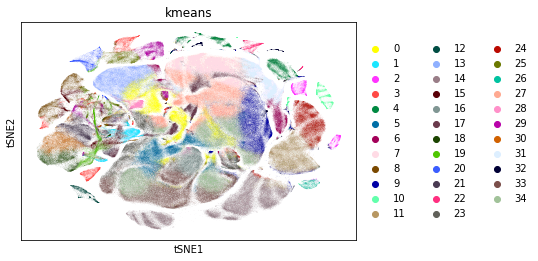

CPU times: user 11.1 s, sys: 61.6 ms, total: 11.1 s
Wall time: 7.22 s


In [22]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

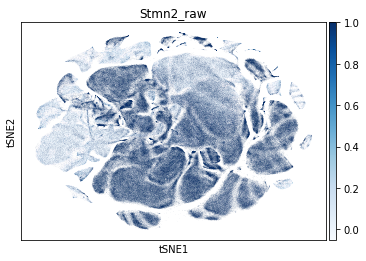

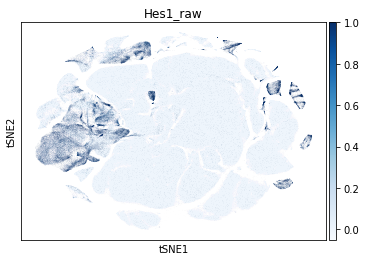

CPU times: user 6.1 s, sys: 27.9 ms, total: 6.12 s
Wall time: 6.12 s


In [23]:
%%time
sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### UMAP + Graph clustering

In [24]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 12min 40s, sys: 5min 48s, total: 18min 29s
Wall time: 3min 5s


In [25]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 2h 18min 15s, sys: 37min 43s, total: 2h 55min 59s
Wall time: 21min 47s


In [26]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 15min 6s, sys: 2.17 s, total: 15min 9s
Wall time: 15min 5s


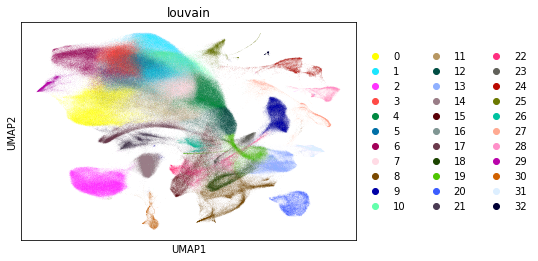

CPU times: user 5.6 s, sys: 18.2 ms, total: 5.62 s
Wall time: 5.62 s


In [27]:
%%time
sc.pl.umap(adata, color=["louvain"])

In [28]:
%%time
# Leiden clustering
sc.tl.leiden(adata)

CPU times: user 51min 8s, sys: 4.11 s, total: 51min 12s
Wall time: 51min 1s


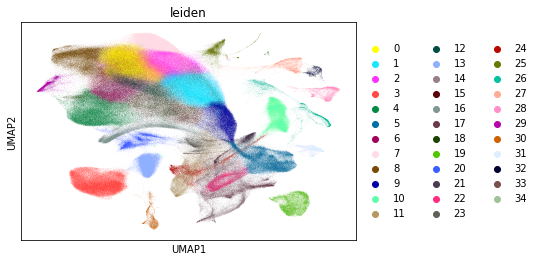

CPU times: user 5.45 s, sys: 22.5 ms, total: 5.47 s
Wall time: 5.47 s


In [29]:
%%time
sc.pl.umap(adata, color=["leiden"])

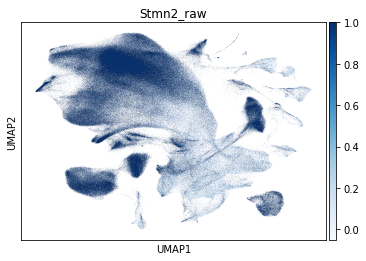

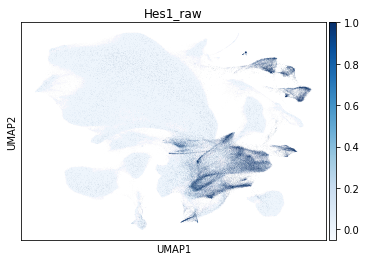

CPU times: user 6.12 s, sys: 1.62 ms, total: 6.12 s
Wall time: 6.12 s


In [30]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

## Create zoomed-in view

In [31]:
reanalysis_start = time.time()

In [32]:
%%time
adata = adata[adata.obs["Hes1_raw"] > 0.0, :]
print(adata.X.shape)

(95916, 4000)
CPU times: user 5.84 s, sys: 324 ms, total: 6.16 s
Wall time: 6.16 s


In [33]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.leiden(adata)

CPU times: user 9min 32s, sys: 2min 42s, total: 12min 14s
Wall time: 2min 31s


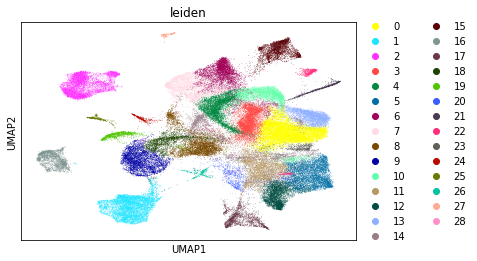

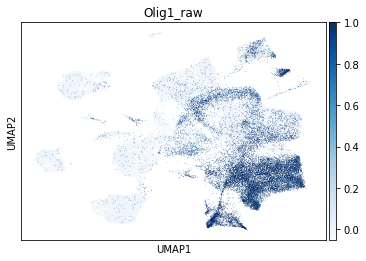

CPU times: user 1.57 s, sys: 15 ms, total: 1.58 s
Wall time: 1.58 s


In [34]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["Olig1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [35]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 159.09698224067688


In [36]:
print("Full time: %s" % (time.time() - start))

Full time: 12707.917050600052
